In [2]:
%matplotlib notebook
%matplotlib inline
from IPython.display import HTML

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import torch
import torch.nn as nn
from torch.nn import functional as F
import pprint as pp
import seaborn as sns
import pandas as pd

### Fitting By Hand

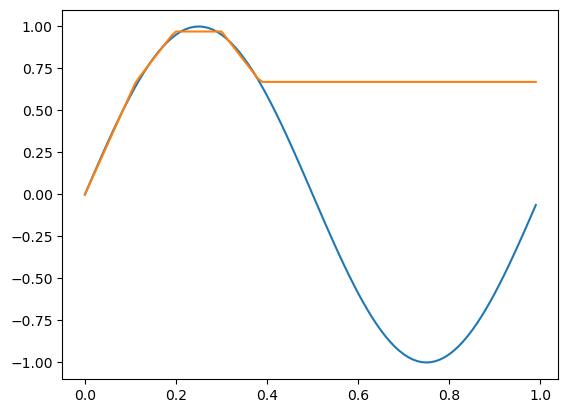

In [2]:
x = np.arange(0, 1, 0.01)
y = np.sin(2 * np.pi *x)

def relu(x): return np.maximum(x, 0)

# first layer
w1 = np.array([6, 3.5, -3.5, -6, 0, 0, 0, 0])
b1 = np.array([0, -0.42, 1.35, 1, 0, 0, 0, 0])

# second layer
w2 = np.array([-1, -1, -1, -1, 0, 0, 0, 0])
b2 = np.array([0.7, 0.27, 0.3, 0, 0, 0, 0, 1])

# output neuron
out = np.array([-1, -1, -1, -1, 0, 0, 0, 0.97])

# forward through the linear layers given input x
# implemented as a one-to-many loop
def forward(x):
    l1 = relu((x * w1 + b1))
    l2 = relu((w2 * l1 + b2))
    return l2 @ out.T

# # for visualization
def plot_nn():
    outputs = np.array([forward(i) for i in x])
    sns.lineplot(x=x, y=y)
    sns.lineplot(x=x, y=outputs)
    plt.show();

plot_nn()

### Numpy Model

In [564]:
def sigmoid(x): return 1 / (1 + np.exp(-x))

class SineNet:
    def __init__(self, X, y, activation):
        self.X, self.y = X, y
        self.activation = activation
        self.iters = 0

        def init(): 
            # return np.array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01])
            return np.random.random(size=8).reshape(1, -1)
            # return np.random.standard_normal(size=8).reshape(1, -1)
        
        self.w1 = init()                   # (1, 8) 
        self.w2 = init()                   # (1, 8)
        self.b1 = init()                   # (1, 8)
        self.b2 = init()                   # (1, 8)

        self.head = init().reshape(-1, 1)  # (8, 1) - output layer

    def act(self, x):
        if self.activation == 'relu':
            return relu(x)
        else:
            return sigmoid(x)

    def training_pass(self, lr = 0.01):
        x = self.X.reshape(-1, 1)
        y = self.y.reshape(-1, 1)
        N = x.shape[0]  # X.shape = (N, 1)

        # forward
        h1 = (x @ self.w1 + self.b1)    # (N, 8)
        l1 = self.act(h1)                   # (N, 8)
        h2 = (self.w2 * l1 + self.b2)   # (N, 8)
        l2 = self.act(h2)                   # (N, 8)

        pred = l2 @ self.head           # (N, 1)

        loss = np.sum((pred - y)**2) / (2 * N)

        # partial derivatives
        dloss = (pred - y) / N                  # (N, 1)
        dl2 = dloss @ self.head.T               # (N, 8)
        dhead = l2.T @ dloss                    # (8, 1)
        
        if self.activation == 'relu':
            dh2 = dl2.copy()                    # (N, 8)
            dh2[h2 < 0] = 0                     # derivative through relu
        else:
            dh2 = l2 * (1 - l2) * dl2           # derivative through sigmoid

        dw2 = (l1 * dh2).sum(0, keepdims=True)  # (1, 8) -- sum bc broadcasting
        dl1 = self.w2 * dh2                     # (N, 8)
        db2 = dh2.sum(0, keepdims=True)         # (1, 8) -- sum bc broadcasting

        if self.activation == 'relu':
            dh1 = dl1.copy()                    # (N, 8)
            dh1[h1 < 0] = 0                     # derivative through relu
        else:
            dh1 = l1 * (1 - l1) * dl1           # derivative through sigmoid

        dx = dh1 @ self.w1.T                    # (N, 1)
        dw1 = x.T @ dh1                         # (1, 8)
        db1 = dh1.sum(0, keepdims=True)         # (1, 8) -- sum bc broadcasting

        # print(f"loss: {loss}, dloss: {dloss}")
        # print(f"dloss: {dloss}, dl2: {dl2}, dh2: {dh2}, dl1: {dl1}, dh1: {dh1}\n")
        # print(f"dhead: {dhead}, dw2: {dw2}, db2: {db2}, dw1: {dw1}, db1: {db1}\n")

        # print(np.max(h1))
        # print(l1)
        # print(h2)
        # print(l2)
        # print('h2:', h2)
        # print('dh2:', )

        # parameter updates
        self.head -= lr * dhead
        self.w2 -= lr * dw2
        self.b2 -= lr * db2
        self.w1 -= lr * dw1
        self.b1 -= lr * db1

        self.iters += 1

        return loss
    
    def get_params(self):
        print('w1')
        pp.pprint(self.w1)
        print('b1')
        pp.pprint(self.b1)
        print('w2')
        pp.pprint(self.w2)
        print('b2')
        pp.pprint(self.b2)
        print('head')
        pp.pprint(self.head)
        

    def forward(self, x):
        h1 = x * self.w1 + self.b1
        l1 = self.act(h1)
        h2 = l1 * self.w2 + self.b2
        l2 = self.act(h2)
        return l2 @ self.head
    
    def loss(self, y, x):
        return (y - self.forward(x))**2

    # for visualization
    def plot_nn(self):
        outputs = self.forward(self.X.reshape(-1, 1))
        sns.lineplot(x=self.X, y=self.y)
        sns.lineplot(x=self.X, y=outputs.reshape(-1))
        plt.title(f"Activation: {self.activation}, Iterations: {self.iters}")
        plt.show();

In [565]:
mod = SineNet(x, y, 'sigmoid')

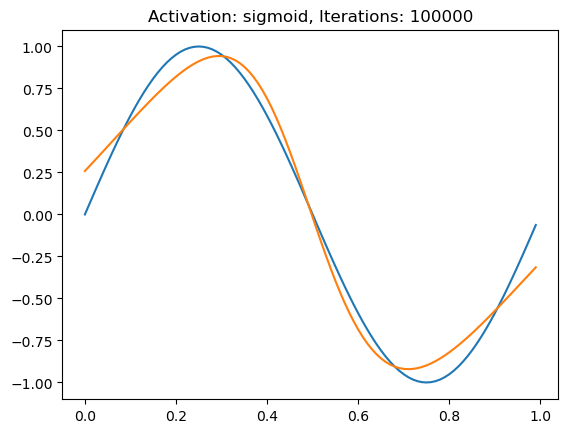

In [665]:
losses = []
epochs = 10
steps = 100
for epoch in range(epochs):
    for step in range(steps):
        l = mod.training_pass(lr=0.1)
        losses.append(l)

mod.plot_nn()    

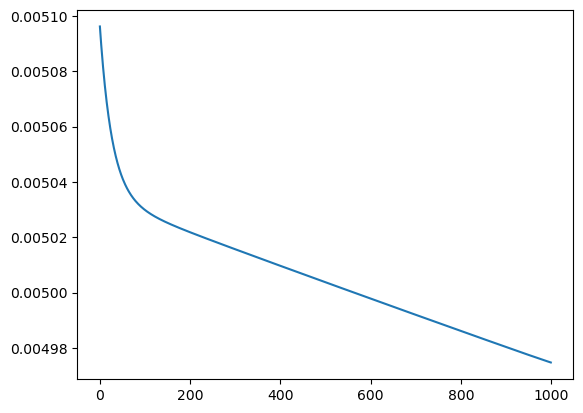

In [666]:
plt.plot(losses);

In [667]:
mod2 = SineNet(x, y, 'relu')

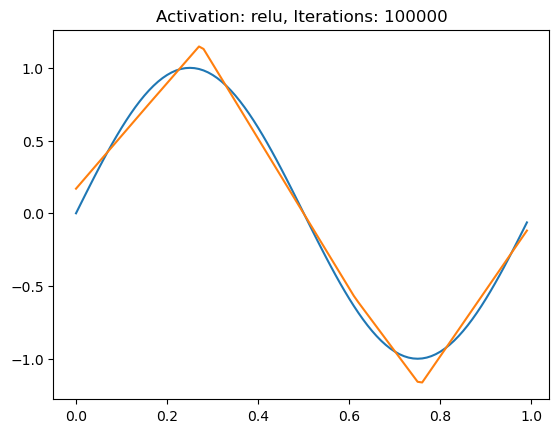

In [767]:
losses = []
epochs = 10
steps = 100
for epoch in range(epochs):
    for step in range(steps):
        l = mod2.training_pass(lr=0.1)
        losses.append(l)

mod2.plot_nn()    

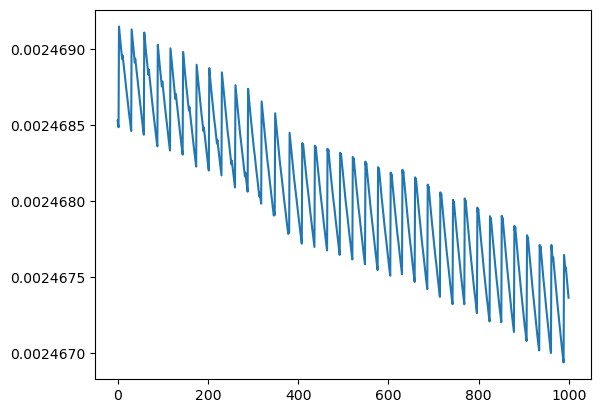

In [768]:
plt.plot(losses);

There's clearly still something weird witht the relu activation.......

### Pytorch Model

In [3]:
torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

device(type='cpu')

In [4]:
x = np.arange(0, 1, 0.01)
y = np.sin(2 * np.pi *x)

x = torch.tensor(x).float().view(-1, 1)
y = torch.tensor(y).float().view(-1, 1)

In [112]:
from collections import OrderedDict

class DirectLayer(nn.Module):
    """
    Custom layer for elementwise multiplication -- i.e. non-fully connected hidden layer
    """
    def __init__(self, size: int=8, scale: float = 1):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, size) / scale)
        self.bias = nn.Parameter(torch.randn(size) / scale)
    
    def forward(self, x):
        return x * self.weights + self.bias


class TorchNet(nn.Module):
    """
    SineNet model in PyTorch
    """
    def __init__(self, activation, size: int = 8, scale: float = 1) -> None:
        super().__init__()
        self.activation = activation
        act = nn.ReLU() if activation == 'relu' else nn.Sigmoid()

        self.layers = nn.Sequential(
            OrderedDict([
                ('h1', nn.Linear(1, size)),
                ('act1', act),
                # ('h2', nn.Linear(size, size)),
                ('h2', DirectLayer(size, scale)),
                ('act2', act),
                ('head', nn.Linear(size, 1, bias=False))
            ])
        )

        self.loss =  nn.MSELoss()
        self.losses = []
        self.iters = 0
        self.size = size


    def forward(self, x, y):
        res = self.layers(x)
        return res, self.loss(res, y)


    def train(self, x, y, lr, steps=100, batch_size=10):
        for step in range(steps):

            # fully random batching
            for batch in range(len(x) // batch_size):
                batch_indices = torch.randint(low=0, high=len(x), size=(batch_size,))
                pred, loss = self.forward(x=x[batch_indices], y=y[batch_indices])

                # clear gradients from last pass
                for p in self.parameters():
                    p.grad = None

                # backwards pass to get new gradients
                loss.backward()

                # update parameters by gradient descent
                for p in self.parameters():
                    p.data -= lr * p.grad

            with torch.no_grad():
                self.losses.append(self.forward(x, y)[1].item())

        self.iters += steps


    def plot_nn(self, x, y):
        with torch.no_grad():
            p, l = self.forward(x, y)
        x = np.array(x).reshape(-1)
        y = np.array(y).reshape(-1)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        rdgn = sns.diverging_palette(h_neg=10, h_pos=130, s=99, l=55, sep=3, as_cmap=True)

        sns.lineplot(x=x, y=y, ax=ax1)
        sns.lineplot(x=x, y=np.array(p).reshape(-1), ax=ax1)
        ax1.set_title(f"Activation: {self.activation}, Iterations: {self.iters}")

        grads = np.array([p.grad.view(-1).detach().numpy() for p in mod.parameters()])
        names = [name for name, _ in self.named_parameters()]
        sns.heatmap(grads, cmap="YlGnBu", yticklabels=names, ax=ax2, center=0)
        plt.show();


    def animate(self, x, y, steps=10, lr=0.1, batch_size=10, frames=20):
        with torch.no_grad(): p, l = self.forward(x, y)
        xn = np.array(x).reshape(-1)
        yn = np.array(y).reshape(-1)
        names = [name[7:] for name, _ in self.named_parameters()]
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6), gridspec_kw={'width_ratios': [1, 2]})
        rdgn = sns.diverging_palette(h_neg=10, h_pos=130, s=99, l=55, sep=3, as_cmap=True)

        def init():  
          sns.lineplot(x=xn, y=yn, ax=ax1)
          sns.lineplot(x=xn, y=np.array(p).reshape(-1), ax=ax1)
          sns.heatmap(
              np.zeros((5, self.size)), cmap=rdgn,
              yticklabels=names, ax=ax2, center=0
          )

        def animate(frame):
            self.train(x, y, lr=lr, steps=steps, batch_size=batch_size)
            with torch.no_grad(): p, l = self.forward(x, y)
            params = np.array([p.view(-1).detach().numpy() for p in self.parameters()])
            ax1.clear()
            ax2.clear()
            sns.lineplot(x=xn, y=yn, ax=ax1)
            sns.lineplot(x=xn, y=np.array(p).reshape(-1), ax=ax1)
            sns.heatmap(params, cmap=rdgn, cbar=False, yticklabels=names, ax=ax2, center=0)
            plt.title(f"Activation: {self.activation}, steps: {self.iters}, Loss: {l.item():,.4f}", loc='left')

        anim = FuncAnimation(fig, animate, init_func=init, frames=frames, interval=500)
        plt.close()
        return anim

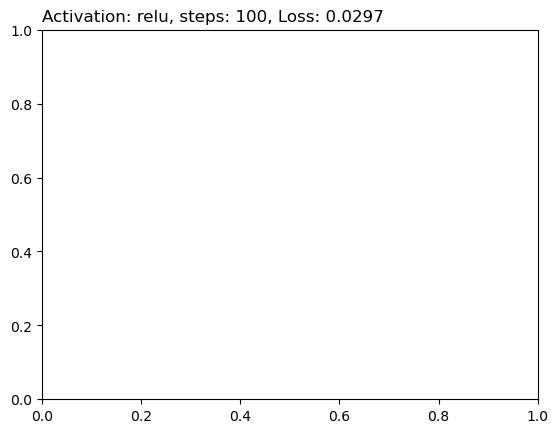

In [113]:
model = TorchNet(activation = 'relu', size = 16, scale=1)
anim = model.animate(x, y, steps=5, lr=0.1, batch_size=10, frames=20)
HTML(anim.to_jshtml())

In [82]:
plt.figure(figsize=(12,4))

xi = x
for layer in model.layers:
    xi = layer(xi)
    xi.retain_grad()
loss = model.loss(xi, y)
loss.backward()

legends = []
l = 0
for layer in model.layers:
    # if isinstance(layer, nn.ReLU):
    #     l += 1
    #     # hy, hx = torch.histogram(xi.grad)#, density=True)
    #     # plt.bar(hx[:-1].detach(), hy.detach())
    #     plt.hist(xi.grad)
    #     legends.append(f'activation {l} ({layer.__class__.__name__})')
    print(len([p for p in layer.parameters()]))
    # print(xi.grad)
# plt.legend(legends)
# plt.title('Activation Distribution')

2
0
2
0
1


<Figure size 1200x400 with 0 Axes>

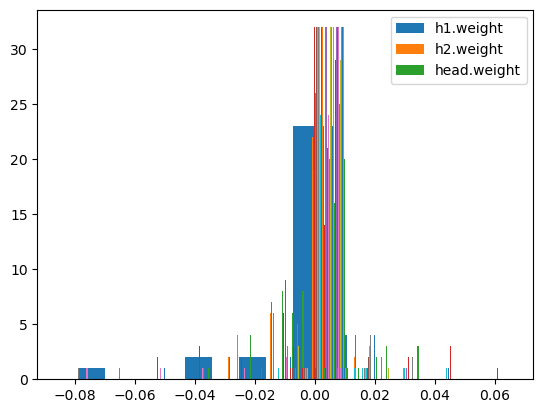

In [85]:
legends = []
for name, p in model.named_parameters():
    if 'bias' not in name:
        plt.hist(p.grad)   
        legends.append(f'{name[7:]}') 

plt.legend(legends)
plt.show();